# oloeriu bogdan: Advanced Lane Finding

do the necessery imports for the project

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

#this is my Camera class. 


In [2]:
class Camera():

    #it creates an calibrated camera object
    def __init__(self):
        self.ret = None
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        self.imageSize = None

        #print ("hello from init function")

        # Read in a calibration image
        images  = glob.glob('./camera_cal/calibration*.jpg')
        #print("images ok")
        #plt.imshow(img)
        #plt.show()

        # Arrays to store object points and image points from all the images
        objpoints = [] #3D points in real world space
        imgpoints = [] #2d points in image plane

        # Prepare oject points, like (0,0,0), (1,0,0), (2,0,0) ...., (7,5,0)
        objp = np.zeros((6*9, 3), np.float32)
        objp[:,:2]  = np.mgrid[0:9, 0:6].T.reshape(-1,2) #x, y coordinates

        for fname in images:
            # read in each image

            img = mpimg.imread(fname)

            # Convert image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            #set the size
            if self.imageSize is None:
                self.imageSize = gray.shape[::-1]

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            # If corners are found, add object points, image points
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)

                # draw and sisplay the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                #plt.imshow(img)
                #plt.show()

                # calibrate camera for this image
                #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
                #undistorted = cv2.undistort(img, mtx, dist, None, mtx)
                #plt.imshow(undistorted)
                #plt.show()
            #else:
                #print ("Corners not found", fname)

        #calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(objpoints, imgpoints, self.imageSize, None, None)

    #it uses cv2 to undistor camera
    def undistort(self, img):
        undistorted = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undistorted

create a calibrated camera object and undistort an immage

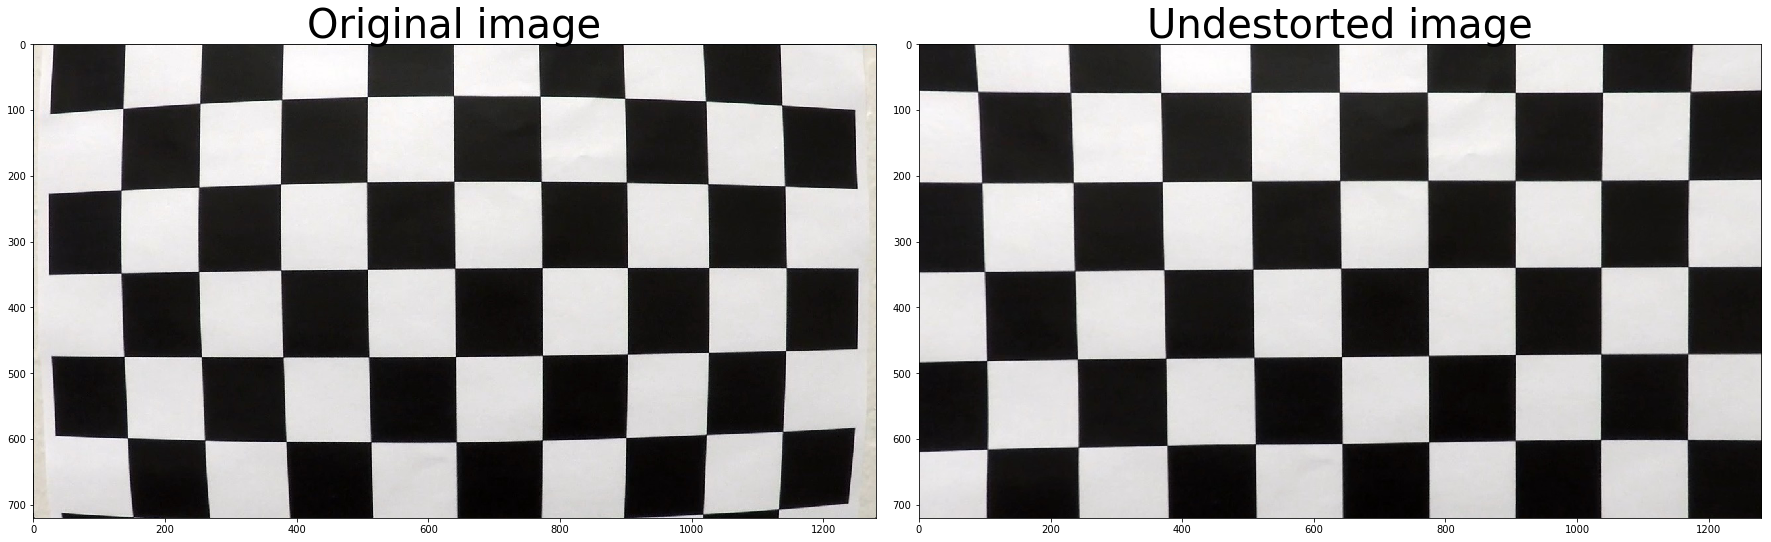

In [5]:

img = mpimg.imread('./camera_cal/calibration1.jpg')

my_camera = Camera()
undestorted_test = my_camera.undistort(img)
#plt.imshow(undestorted_test)
#plt.imshow(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


ax1.imshow(img)
ax1.set_title('Original image', fontsize=40)

ax2.imshow(undestorted_test)
ax2.set_title('Undestorted image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [39]:


# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    
    return combined_binary
    


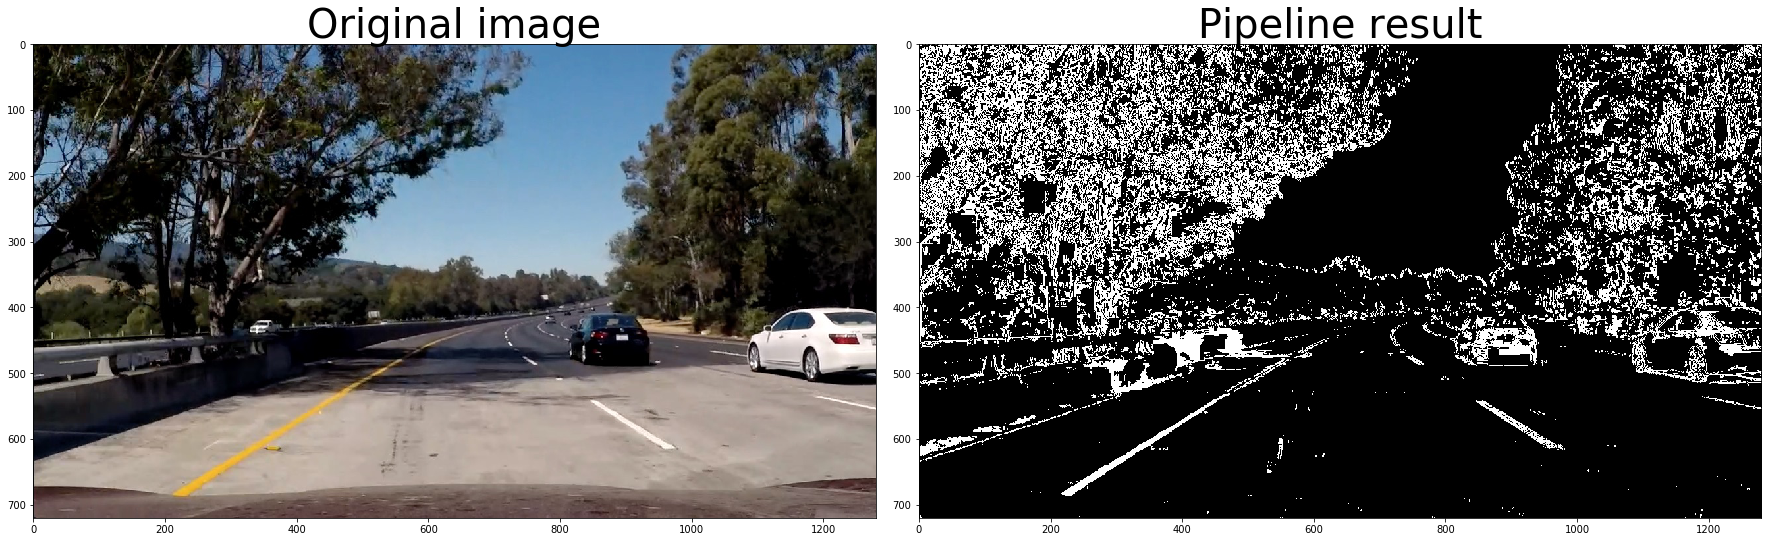

In [40]:
image = mpimg.imread('./camera_cal/color-shadow-example.jpg')
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

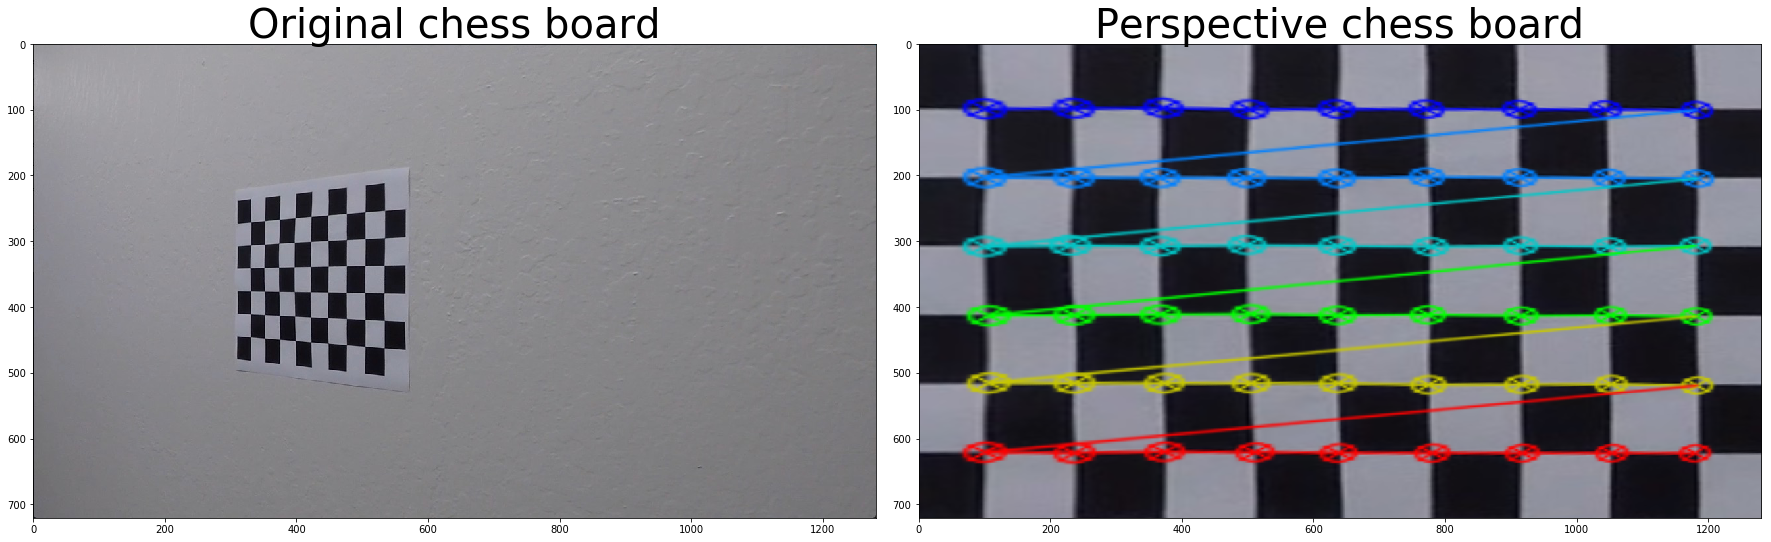

In [46]:
def corners_unwarp(img, nx, ny):
    # Use my camera to remove distortion
    undist = my_camera.undistort(img)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

img = mpimg.imread('./camera_cal/calibration7.jpg')
top_down, perspective_M = corners_unwarp(img, 9, 6)

# Plot perspective result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original chess board', fontsize=40)

ax2.imshow(top_down)
ax2.set_title('Perspective chess board', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()